# Dimensionality Reduction Methods:
We apply different techniques for dimensionality reduction to visualize and interpret the structure of high-dimensional data.

- **Principal Component Analysis (PCA)**:  
  is a linear technique that reduces dimensionality by projecting data onto the directions that capture the most variance.


- **t-SNE (t-Distributed Stochastic Neighbor Embedding)**:  
  is a non-linear technique that preserves local structure by minimizing the Kullback-Leibler (KL) divergence between pairwise similarities in high- and low-dimensional spaces.

- **Linear Discriminant Analysis (LDA)**:  
  is a supervised technique that maximizes class separation by projecting data onto a linear combination of features that best separates different classes.

## Libraries

In [ ]:
## Import Required Libraries
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import math
from collections import Counter

## Synthetic Data

1. **Synthetic Dataset Creation**:
   - We generate a synthetic dataset using the `make_blobs()` function from `sklearn`. The dataset consists of 300 samples, each with 5 features, and is divided into 3 clusters. The true cluster labels are stored in `y`.

2. **Normalization**:
   - After generating the dataset, we apply Min-Max normalization using `MinMaxScaler` to scale the data into the range $[0, 1]$. This normalization ensures that all features have comparable scales, which is especially important for distance-based algorithms like PCA and K-Means.

3. **Data Visualization**:
   - Although the dataset has 5 features, we visualize only the first two dimensions of the data to get an intuitive sense of its structure. The plot shows the spread of data in the first two dimensions, giving us a glimpse of how the clusters are distributed in the original high-dimensional space.

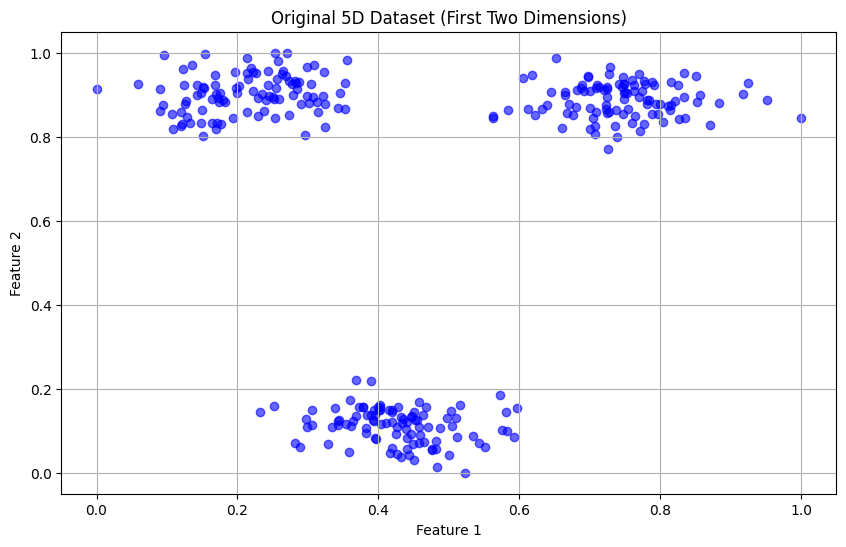

In [ ]:
## Set Random Seed for Reproducibility
torch.manual_seed(42)

## Generate Synthetic Dataset with 5 features
n_samples = 300
n_features = 5
n_clusters = 3
X_numpy, y = make_blobs(n_samples=n_samples, centers=n_clusters, n_features=n_features, random_state=42)
y = torch.tensor(y, dtype=torch.long)

## Normalize the Data: We apply min-max normalization to scale the data to the range [0, 1].
scaler = MinMaxScaler() # You can also use RobustScaler(), MaxAbsScaler(), StandardScaler()
X_normalized_numpy = scaler.fit_transform(X_numpy)
X = torch.tensor(X_normalized_numpy, dtype=torch.float32)

## Visualize the Original Dataset (First Two Dimensions Only)
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], color='blue', alpha=0.6)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Original 5D Dataset (First Two Dimensions)')
plt.grid(True)
plt.show()

## Principal Component Analysis (PCA)
Principal Component Analysis (PCA) reduces the dimensionality of a dataset by projecting it onto directions (principal components) that capture the most variance. PCA works by first centering the data and then computing the covariance matrix:
$$
\text{Cov}(X) = \frac{1}{n-1} X_{centered}^T X_{centered}
$$
We then perform eigenvalue decomposition:
$$
C v = \lambda v
$$
where $v$ are the eigenvectors (principal components) and $\lambda$ are the corresponding eigenvalues (variance explained). The data is then projected onto the selected components:
$$
X_{pca} = X_{centered} V_k
$$


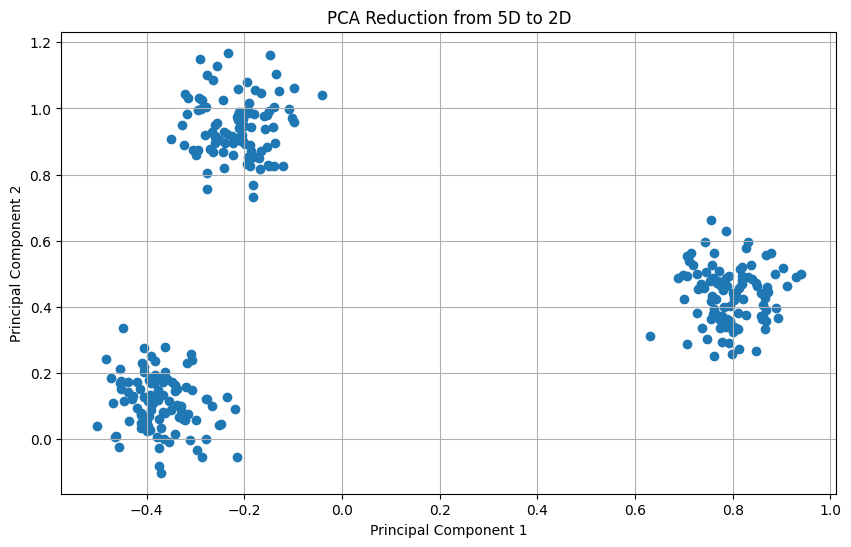

In [ ]:
def pca(X, n_components):
    """
    Perform Principal Component Analysis (PCA) for dimensionality reduction.

    Parameters:
    - X: A tensor of data points (features).
    - n_components: The number of principal components to compute.

    Returns:
    - X_pca: The data projected onto the selected principal components.
    """

    # Center the data by subtracting the mean of each feature from the data points
    X_meaned = X - X.mean(0)

    # Compute the covariance matrix from the centered data
    covariance_matrix = X_meaned.T @ X_meaned / (X.shape[0] - 1)

    # Compute the eigenvalues and eigenvectors of the covariance matrix
    L_complex, V_complex = torch.linalg.eig(covariance_matrix)

    # Extract the real part of the eigenvalues and eigenvectors
    L = L_complex.real
    V = V_complex.real

    # Sort the eigenvalues in descending order and get the corresponding eigenvectors
    idx = L.argsort(descending=True)
    V = V[:, idx]

    # Select the top n_components eigenvectors (principal components)
    principal_components = V[:, :n_components]

    # Project the data onto the selected principal components
    return X @ principal_components


# Apply PCA to reduce from 5 dimensions to 2 dimensions
X_pca = pca(X, 2)

# Plot the PCA result
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title('PCA Reduction from 5D to 2D')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

## t-Distributed Stochastic Neighbor Embedding (t-SNE)

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a non-linear dimensionality reduction technique used for visualizing high-dimensional data, especially useful for uncovering clusters.

1. **High-Dimensional Pairwise Similarities**:  
   The similarity between points \( i \) and \( j \) in the high-dimensional space is computed using a Gaussian distribution:
   $$
   P_{ij} = \frac{\exp\left(-\frac{\|x_i - x_j\|^2}{2 \sigma_i^2}\right)}{\sum_{k \neq i} \exp\left(-\frac{\|x_i - x_k\|^2}{2 \sigma_i^2}\right)}
   $$
   where \( \sigma_i \) is chosen to match the desired perplexity.

2. **Low-Dimensional Similarities**:  
   In the low-dimensional space, similarities are modeled using a Student-t distribution:
   $$
   Q_{ij} = \frac{\left(1 + \|y_i - y_j\|^2\right)^{-1}}{\sum_{k \neq l} \left(1 + \|y_k - y_l\|^2\right)^{-1}}
   $$

3. **KL Divergence and Optimization**:  
   t-SNE minimizes the Kullback-Leibler divergence between the high- and low-dimensional distributions:
   $$
   \text{KL}(P \| Q) = \sum_{i} \sum_{j} P_{ij} \log \frac{P_{ij}}{Q_{ij}}
   $$
   Gradient descent is used to optimize the low-dimensional representation \( y_i \) to preserve the local structure of the data.


Iteration 0 / 2000, KL Divergence: 0.8650912046432495
Iteration 500 / 2000, KL Divergence: 0.010210884734988213
Iteration 1000 / 2000, KL Divergence: 0.000664173741824925
Iteration 1500 / 2000, KL Divergence: 9.81217235676013e-05


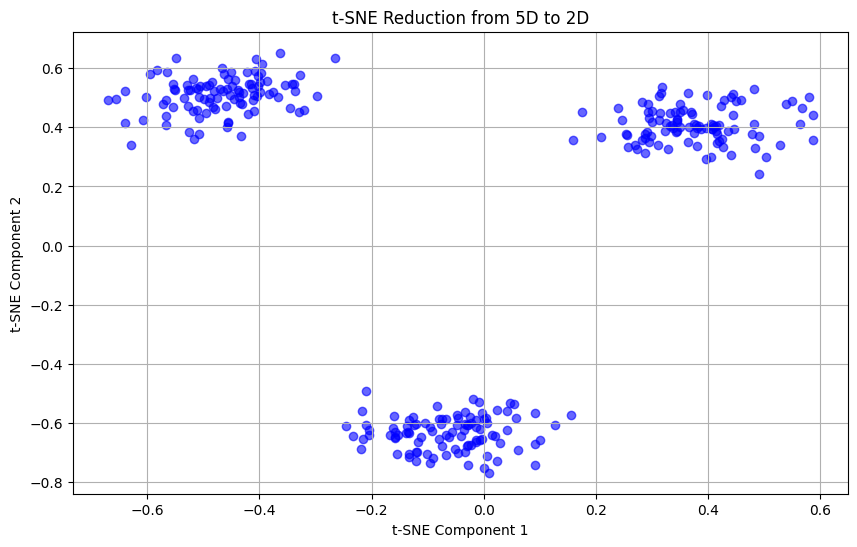

In [ ]:
class TSNE:
    """
    t-Distributed Stochastic Neighbor Embedding (t-SNE) implementation for dimensionality reduction.

    Parameters:
    - n_components: Number of components for low-dimensional projection (default 2).
    - perplexity: Desired perplexity, controls the local-global balance in the similarity matrix.
    - learning_rate: Learning rate for the gradient descent optimization (default 10.0).
    - n_iter: Number of iterations to run the optimization (default 2000).
    - sigma: Bandwidth parameter for the Gaussian kernel in the similarity matrix (default 1.0).

    Methods:
    - pairwise_distances: Compute pairwise distances between all points in the dataset.
    - compute_similarity_matrix: Compute the similarity matrix using a Gaussian kernel.
    - fit_transform: Perform t-SNE for dimensionality reduction and return the low-dimensional embeddings.

    Returns:
    - Y: Low-dimensional representation of the data after t-SNE optimization.
    """

    def __init__(self, n_components=2, perplexity=30.0, learning_rate=10.0, n_iter=2000, sigma=1.0):
        """
        Initialize t-SNE parameters.

        Parameters:
        - n_components: Number of components for low-dimensional projection (default 2).
        - perplexity: Desired perplexity, controls the local-global balance in the similarity matrix.
        - learning_rate: Learning rate for the gradient descent optimization (default 10.0).
        - n_iter: Number of iterations to run the optimization (default 2000).
        - sigma: Bandwidth parameter for the Gaussian kernel in the similarity matrix (default 1.0).
        """
        self.n_components = n_components
        self.perplexity = perplexity
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.sigma = sigma

    def pairwise_distances(self, X):
        """
        Compute pairwise distances between all points in the dataset.

        Parameters:
        - X: Tensor of data points.

        Returns:
        - distances: Tensor of pairwise distances between the points.
        """
        sum_X = torch.sum(X ** 2, dim=1)
        distances = torch.sqrt(F.relu(sum_X.unsqueeze(1) + sum_X.unsqueeze(0) - 2 * torch.matmul(X, X.T)))
        return distances

    def compute_similarity_matrix(self, distances):
        """
        Compute the similarity matrix using a Gaussian kernel.

        Parameters:
        - distances: Pairwise distances between points.

        Returns:
        - sim_matrix: The similarity matrix where entries represent probabilities of proximity.
        """
        sim_matrix = torch.exp(-distances ** 2 / (2 * self.sigma ** 2))
        sim_matrix = sim_matrix / sim_matrix.sum()
        return sim_matrix

    def fit_transform(self, X):
        """
        Perform t-SNE for dimensionality reduction.

        Parameters:
        - X: Tensor of high-dimensional data points.

        Returns:
        - Y: Low-dimensional representation of the data.
        """
        n_samples, n_features = X.shape

        # Step 1: Compute pairwise distances in high-dimensional space
        high_dim_distances = self.pairwise_distances(X)

        # Step 2: Compute similarities in high-dimensional space (P matrix)
        P = self.compute_similarity_matrix(high_dim_distances)

        # Step 3: Initialize random low-dimensional representation
        Y = torch.randn(n_samples, self.n_components, requires_grad=True)  # Low-dimensional embeddings

        # Use stochastic gradient descent (SGD) for optimization
        optimizer = torch.optim.SGD([Y], lr=self.learning_rate)

        # Gradient Descent to minimize KL divergence between high- and low-dimensional similarities
        for i in range(self.n_iter):
            optimizer.zero_grad()  # Clear gradients from the previous iteration

            # Step 4: Compute pairwise distances in low-dimensional space
            low_dim_distances = self.pairwise_distances(Y)

            # Compute similarities in low-dimensional space (Q matrix)
            Q = self.compute_similarity_matrix(low_dim_distances)

            # Step 5: Compute the Kullback-Leibler (KL) divergence between P and Q
            kl_divergence = torch.sum(P * torch.log(P / (Q + 1e-9)))  # KL divergence

            # Backpropagate the gradient of KL divergence
            kl_divergence.backward()

            # Step 6: Update low-dimensional embeddings with gradient descent
            optimizer.step()

            # Print progress every 500 iterations
            if i % 500 == 0:
                print(f"Iteration {i} / {self.n_iter}, KL Divergence: {kl_divergence.item()}")

        return Y  # Return the optimized low-dimensional embeddings


# Apply t-SNE to the 5D dataset
tsne = TSNE(n_components=2, learning_rate=10.0, n_iter=2000)
X_tsne = tsne.fit_transform(X)  # X is your high-dimensional data

# Visualize the t-SNE result
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0].detach().numpy(), X_tsne[:, 1].detach().numpy(), color='blue', alpha=0.6)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Reduction from 5D to 2D')
plt.grid(True)
plt.show()


## Linear Discriminant Analysis (LDA)

Linear Discriminant Analysis (LDA) is a supervised dimensionality reduction technique that maximizes the separation between multiple classes by finding a linear combination of features that best separates them. LDA works by computing two scatter matrices:

1. **Within-class scatter matrix** $S_W $:
   $$
   S_W = \sum_{c=1}^{C} \sum_{x_i \in c} (x_i - \mu_c)(x_i - \mu_c)^T
   $$
   where $\mu_c$is the mean of class $c$ and $x_i$ are the samples in that class.

2. **Between-class scatter matrix** $S_B $:
   $$
   S_B = \sum_{c=1}^{C} N_c (\mu_c - \mu)(\mu_c - \mu)^T
   $$
   where $\mu$ is the overall mean of the data, and $N_c$ is the number of samples in class $c$.

We then solve the eigenvalue problem:
$$
S_W^{-1} S_B v = \lambda v
$$
where $v $ are the eigenvectors (linear discriminants) and $\lambda$ are the eigenvalues (separation explained). The data is projected onto these linear discriminants for dimensionality reduction.


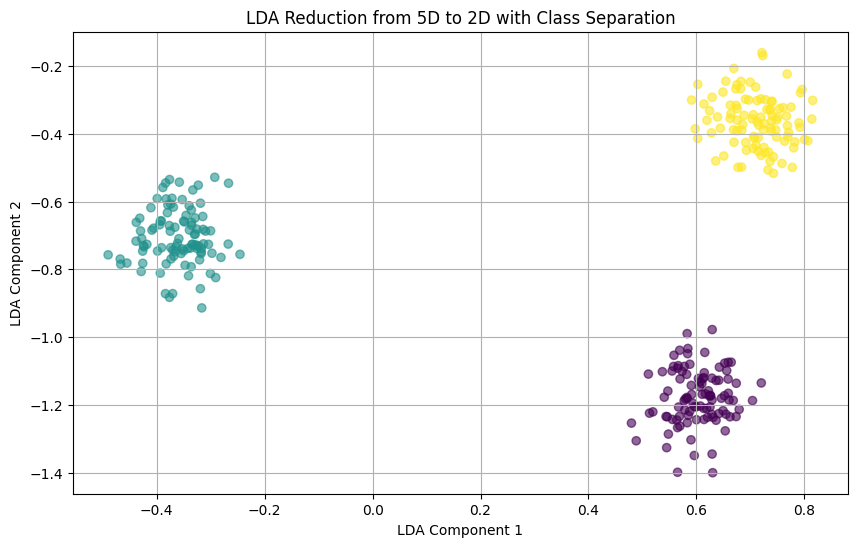

In [ ]:
def lda(X, y, n_components=2):
    """
    Perform Linear Discriminant Analysis (LDA) for dimensionality reduction.

    Parameters:
    - X: A tensor of data points (features).
    - y: The class labels for the data points.
    - n_components: The number of linear discriminants to compute (default 2).

    Returns:
    - X_lda: The data projected onto the new linear discriminants.
    """

    n_features = X.shape[1]
    class_labels = torch.unique(y)

    # Compute the overall mean of the dataset
    mean_overall = torch.mean(X, dim=0)

    # Initialize scatter matrices
    S_W = torch.zeros((n_features, n_features))
    S_B = torch.zeros((n_features, n_features))

    # Compute within-class and between-class scatter matrices
    for label in class_labels:
        X_c = X[y == label]
        mean_c = torch.mean(X_c, dim=0)

        # Within-class scatter matrix
        S_W += (X_c - mean_c).T @ (X_c - mean_c)

        # Between-class scatter matrix
        n_c = X_c.shape[0]
        mean_diff = (mean_c - mean_overall).unsqueeze(1)
        S_B += n_c * (mean_diff @ mean_diff.T)

    # Solve the eigenvalue problem for S_W^-1 * S_B
    eigvals, eigvecs = torch.linalg.eig(torch.linalg.inv(S_W) @ S_B)

    # Select the top eigenvectors (linear discriminants)
    eigvals = eigvals.real  # Remove imaginary part if any
    eigvecs = eigvecs.real  # Remove imaginary part
    idx = eigvals.argsort(descending=True)[:n_components]
    W = eigvecs[:, idx]

    # Project the data onto the new linear discriminants
    X_lda = X @ W
    return X_lda

# Apply LDA to the dataset
X_lda = lda(X, y, n_components=2)

# Visualize the LDA result
plt.figure(figsize=(10, 6))
plt.scatter(X_lda[:, 0].detach().numpy(), X_lda[:, 1].detach().numpy(), c=y.numpy(), cmap='viridis', alpha=0.6)
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('LDA Reduction from 5D to 2D with Class Separation')
plt.grid(True)
plt.show()


# Clustering Methods:
We use clustering algorithms to group the data into clusters after dimensionality reduction.

- **K-Means Clustering**:  
  partitions the data into $k$ clusters by minimizing the within-cluster sum of squares (WCSS)

- **Gaussian Mixture Model (GMM)**:  
  models the data as a mixture of Gaussian distributions, where each data point is assigned to a cluster with a certain probability. The objective is to maximize the likelihood of the data given the mixture of Gaussians.

- **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**:  
  is a density-based clustering algorithm that groups points closely packed together. It identifies **core points** with at least min_samples neighbors within an $\varepsilon$-radius and labels others as **border points** or **noise**.

- **Gini Impurity & Decision Trees**:  
  recursively split data based on features to maximize class separationand measures the "impurity" of a split. The tree grows by splitting nodes to minimize Gini impurity, stopping based on criteria such as depth or purity.


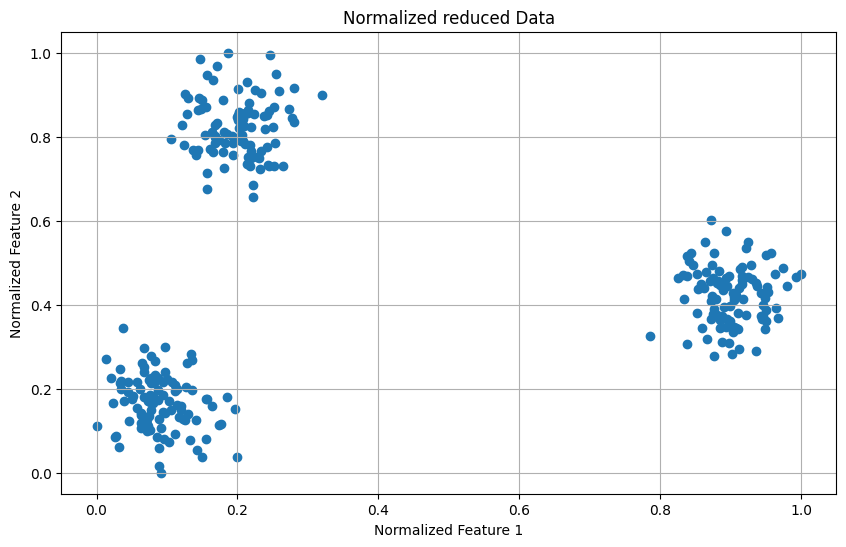

In [ ]:
# Choose the reduced data set
X_reduced = X_pca  # You can also use X_tsne or X_lda

# Normalize the reduced data
X_reduced = scaler.fit_transform(X_reduced.numpy())
X_reduced = torch.tensor(X_reduced, dtype=torch.float32)

# Visualize the GMM clustering result
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
plt.title('Normalized reduced Data')
plt.xlabel('Normalized Feature 1')
plt.ylabel('Normalized Feature 2')
plt.grid(True)
plt.show()

## K-means Clustering
K-means clustering aims to partition $n$ observations into $k$ clusters in which each observation belongs to the cluster with the nearest mean. The objective is to minimize the within-cluster sum of squares (WCSS):
$$
J = \sum_{i=1}^{k} \sum_{x \in C_i} ||x - \mu_i||^2
$$


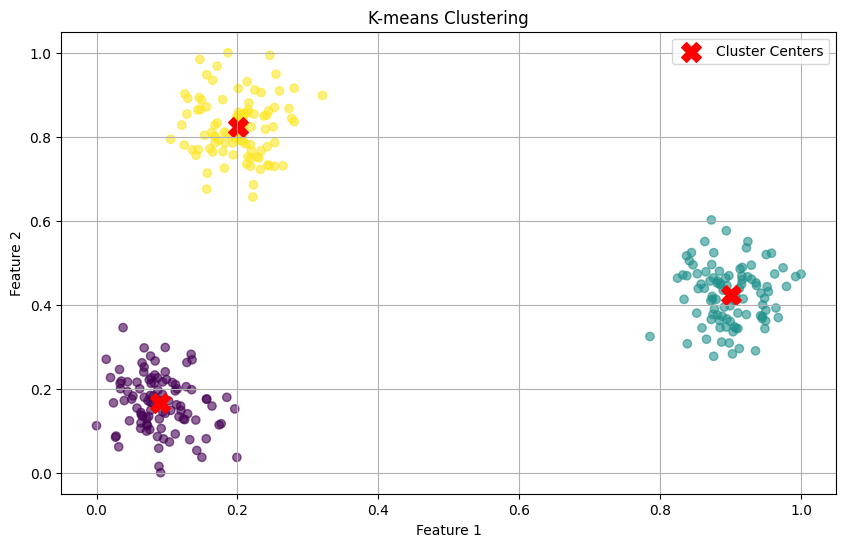

In [ ]:
def k_means_clustering(X, n_clusters, max_iterations=100, tolerance=1e-4):
    """
    Perform K-means clustering on the provided data.

    Parameters:
    - X: A tensor of data points to cluster.
    - n_clusters: The number of clusters to find.
    - max_iterations: The maximum number of iterations to perform (default 100).
    - tolerance: The convergence tolerance (default 1e-4).

    Returns:
    - cluster_centers: The coordinates of the n_clusters cluster centers.
    - cluster_assignments: Index of the cluster each data point is assigned to.
    """

    # Initialize cluster centers randomly
    initial_centers_indices = torch.randperm(X.size(0))[:n_clusters]
    cluster_centers = X[initial_centers_indices]

    for iteration in range(max_iterations):
        # Calculate distances between data points and cluster centers
        distances = torch.cdist(X, cluster_centers)

        # Assign each data point to the closest cluster
        cluster_assignments = torch.argmin(distances, dim=1)

        # Update cluster centers
        new_centers = torch.stack([X[cluster_assignments == k].mean(dim=0) for k in range(n_clusters)])

        # Check for convergence
        if torch.all(torch.abs(new_centers - cluster_centers) < tolerance):
            break

        cluster_centers = new_centers

    return cluster_centers, cluster_assignments

# Perform and Visualize K-means Clustering
cluster_centers, cluster_assignments = k_means_clustering(X_reduced, n_clusters)

plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cluster_assignments.numpy(), cmap='viridis', alpha=0.6)
plt.scatter(cluster_centers[:, 0].numpy(), cluster_centers[:, 1].numpy(), marker='X', s=200, color='red', label='Cluster Centers')
plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

## Gaussian Mixture Model (GMM)
Gaussian Mixture Model (GMM) is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions. The probability density function (PDF) of a Gaussian distribution is given by:
$$
p(x) = \frac{1}{\sqrt{(2 \pi)^d |\Sigma|}} \exp\left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right)
$$

The EM algorithm is used to find the parameters that maximize the likelihood of the data.

- **E-step**: Calculate the responsibilities based on the current parameters.
- **M-step**: Update the parameters using the calculated responsibilities.

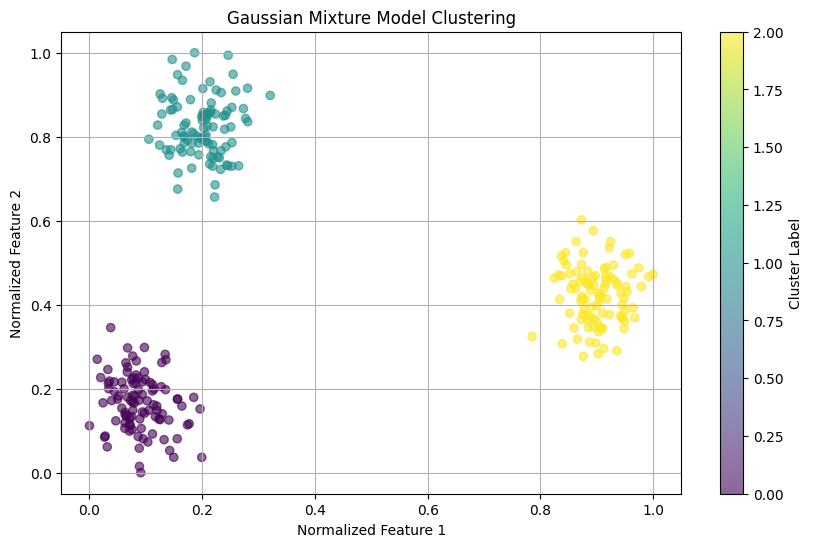

In [ ]:
class GaussianMixtureModel:
    """
    A Gaussian Mixture Model (GMM) implementation for clustering, using the Expectation-Maximization (EM) algorithm.

    Parameters:
    - n_components: The number of Gaussian distributions (clusters) to fit to the data.
    - max_iterations: The maximum number of iterations for the EM algorithm (default 100000).
    - tolerance: The convergence tolerance for the log-likelihood (default 1e-9).

    Methods:
    - initialize_parameters: Randomly initialize the means, covariances, and weights for the GMM.
    - gaussian_pdf: Compute the probability density function of a multivariate Gaussian distribution.
    - fit: Fit the GMM to the provided data using the EM algorithm.
    - predict: Predict the cluster assignments for new data based on the fitted GMM.

    Returns:
    - Means: The means of the fitted Gaussian components.
    - Covariances: The covariance matrices of the fitted Gaussian components.
    - Weights: The weights (mixing coefficients) for each Gaussian component.
    - Cluster Assignments: The predicted cluster for each data point.
    """

    def __init__(self, n_components, max_iterations=100000, tolerance=1e-9):
        """
        Initialize Gaussian Mixture Model (GMM) parameters.

        Parameters:
        - n_components: The number of Gaussian distributions (clusters) to fit to the data.
        - max_iterations: The maximum number of iterations for the Expectation-Maximization algorithm (default 100000).
        - tolerance: The convergence tolerance for the log-likelihood (default 1e-9).
        """
        self.n_components = n_components
        self.max_iterations = max_iterations
        self.tolerance = tolerance

    def initialize_parameters(self, X):
        """
        Initialize the parameters for the GMM.

        Parameters:
        - X: Tensor of data points.

        Returns:
        - Initializes the means, covariances, and weights for the GMM.
        """

        n_samples, n_features = X.shape
        # Randomly select initial means from the data points
        self.means = X[torch.randperm(n_samples)[:self.n_components]]

        # Initialize covariances as identity matrices
        self.covariances = torch.stack([torch.eye(n_features) for _ in range(self.n_components)])

        # Initialize weights equally
        self.weights = torch.ones(self.n_components) / self.n_components

    def gaussian_pdf(self, X, mean, covariance):
        """
        Compute the multivariate Gaussian probability density function (PDF).

        Parameters:
        - X: Tensor of data points.
        - mean: The mean vector of the Gaussian distribution.
        - covariance: The covariance matrix of the Gaussian distribution.

        Returns:
        - The probability density for each data point.
        """

        n_features = X.shape[1]
        # Compute the difference between data points and the mean
        diff = X - mean

        # Compute the inverse of the covariance matrix (with small value added for numerical stability)
        inv_cov = torch.linalg.inv(covariance)

        # Compute the exponential term of the Gaussian PDF
        exp_term = torch.exp(-0.5 * torch.sum(diff @ inv_cov * diff, dim=1))

        # Compute the normalization coefficient
        coef = 1 / (math.sqrt((2 * math.pi) ** n_features * torch.det(covariance)))

        return coef * exp_term

    def fit(self, X):
        """
        Fit the Gaussian Mixture Model to the data using the Expectation-Maximization (EM) algorithm.

        Parameters:
        - X: Tensor of data points.

        Returns:
        - Updates the means, covariances, and weights of the GMM to best fit the data.
        """

        n_samples, _ = X.shape
        self.initialize_parameters(X)
        log_likelihoods = []

        for iteration in range(self.max_iterations):
            # E-step: calculate the responsibilities (probability of each point belonging to each Gaussian)
            responsibilities = torch.zeros((n_samples, self.n_components))
            for k in range(self.n_components):
                responsibilities[:, k] = self.weights[k] * self.gaussian_pdf(X, self.means[k], self.covariances[k])

            # Normalize responsibilities (so each row sums to 1)
            responsibilities = responsibilities / responsibilities.sum(dim=1, keepdim=True)

            # M-step: update the parameters based on the responsibilities
            N_k = responsibilities.sum(dim=0)  # Effective number of points assigned to each component

            # Update weights
            self.weights = N_k / n_samples

            # Update means
            self.means = torch.stack([torch.sum(responsibilities[:, k].unsqueeze(1) * X, dim=0) / N_k[k] for k in range(self.n_components)])

            # Update covariances
            self.covariances = torch.stack([
                (responsibilities[:, k].unsqueeze(1) * (X - self.means[k])).T @ (X - self.means[k]) / N_k[k]
                for k in range(self.n_components)
            ])

            # Compute the log likelihood for convergence check
            weighted_pdf = torch.zeros((n_samples, self.n_components))
            for k in range(self.n_components):
                weighted_pdf[:, k] = self.weights[k] * self.gaussian_pdf(X, self.means[k], self.covariances[k])

            # Total log likelihood
            log_likelihood = torch.sum(torch.log(weighted_pdf.sum(dim=1)))
            log_likelihoods.append(log_likelihood)

            # Check for convergence
            if iteration > 0 and torch.abs(log_likelihoods[-1] - log_likelihoods[-2]) < self.tolerance:
                break

    def predict(self, X):
        """
        Predict the cluster assignments for each data point based on the fitted GMM.

        Parameters:
        - X: Tensor of data points to cluster.

        Returns:
        - The predicted cluster assignment for each data point.
        """

        # Compute responsibilities for the data
        responsibilities = torch.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            responsibilities[:, k] = self.weights[k] * self.gaussian_pdf(X, self.means[k], self.covariances[k])

        # Assign each point to the cluster with the highest responsibility
        return torch.argmax(responsibilities, dim=1)


# Perform and Visualize GMM Clustering
gmm = GaussianMixtureModel(n_components=n_clusters)
gmm.fit(X_reduced)
gmm_clusters = gmm.predict(X_reduced)

plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=gmm_clusters.numpy(), cmap='viridis', alpha=0.6)
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('Normalized Feature 1')
plt.ylabel('Normalized Feature 2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

## Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

Density-Based Spatial Clustering of Applications with Noise (DBSCAN) is a clustering algorithm that groups together points that are closely packed, marking points that lie alone in low-density regions as noise. It does not assume any predefined distribution and can discover clusters of arbitrary shapes.

The epsilon-neighborhood of a point \( x_i \) is defined as:
$$
N_\varepsilon(x_i) = \{ x_j \in X \mid \|x_i - x_j\| \leq \varepsilon \}
$$

A point \$x_i$ is classified as:
- A **core point** if the number of points in its neighborhood is at least the minimum number of samples:
$$
|N_\varepsilon(x_i)| \geq min_\textrm{samples}
$$
- A **border point** if it is within the neighborhood of a core point but does not have enough neighbors to be a core point.
- A **noise point** if it is not reachable from any core point.

DBSCAN uses a density-based approach where:
- **Core Points** are the central points of dense clusters.
- **Border Points** connect to core points but do not have enough neighbors to be core points.
- **Noise Points** are outliers and are not part of any cluster.


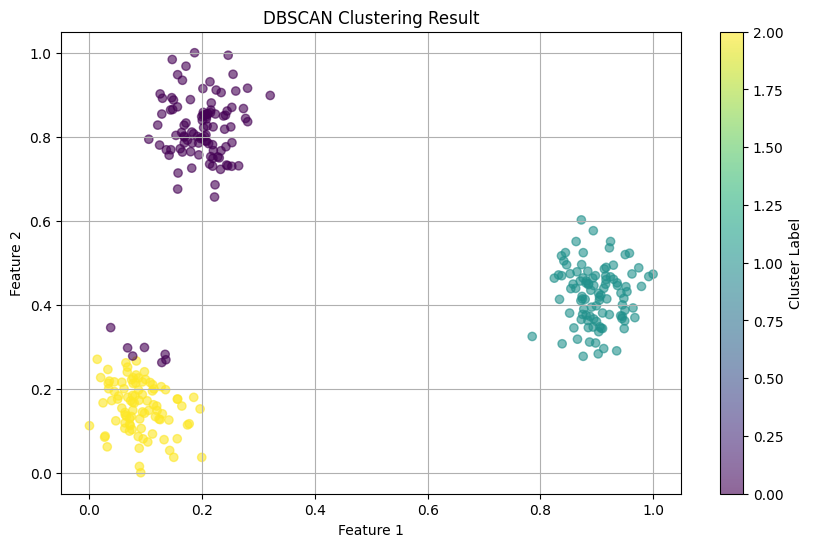

In [ ]:
class DBSCAN:
    """
    Density-Based Spatial Clustering of Applications with Noise (DBSCAN) for clustering.

    Parameters:
    - eps: The maximum distance between two samples for them to be considered as in the same neighborhood (default 0.5).
    - min_samples: The number of samples in a neighborhood for a point to be considered a core point (default 5).

    Methods:
    - fit_predict: Performs DBSCAN clustering on the dataset and returns the cluster assignments.

    Returns:
    - labels: Cluster labels for each data point (-1 for noise).
    """

    def __init__(self, eps=0.5, min_samples=5):
        """
        Initialize DBSCAN parameters.

        Parameters:
        - eps: The maximum distance between two samples for them to be considered neighbors.
        - min_samples: The number of samples in a neighborhood for a point to be considered a core point.
        """
        self.eps = eps
        self.min_samples = min_samples

    def fit_predict(self, X):
        """
        Perform DBSCAN clustering on the dataset.

        Parameters:
        - X: Tensor of data points (features).

        Returns:
        - labels: Cluster labels for each data point (-1 for noise).
        """
        # Convert the data to a numpy array
        X_np = X.numpy()

        # Find the nearest neighbors for each point
        neighbors = NearestNeighbors(radius=self.eps).fit(X_np)
        distances, indices = neighbors.radius_neighbors(X_np)

        # Initialize labels as -1 for noise
        labels = torch.full((X.shape[0],), -1, dtype=torch.long)
        cluster_id = 0

        # Iterate over each point
        for point_idx in range(X.shape[0]):
            if labels[point_idx] != -1:  # Skip if already labeled
                continue

            # Get neighbors within the eps radius
            neighbors_within_eps = indices[point_idx]

            if len(neighbors_within_eps) < self.min_samples:  # Mark as noise if not enough neighbors
                continue

            # Start a new cluster
            labels[point_idx] = cluster_id
            stack = list(neighbors_within_eps)

            # Expand the cluster
            while stack:
                neighbor_idx = stack.pop()

                if labels[neighbor_idx] == -1:  # If the point is labeled as noise, make it part of the cluster
                    labels[neighbor_idx] = cluster_id

                if labels[neighbor_idx] != -1:  # If already labeled, skip
                    continue

                # Add the point to the cluster
                labels[neighbor_idx] = cluster_id

                # Expand the cluster if the neighbor has enough points within eps
                neighbors_of_neighbor = indices[neighbor_idx]
                if len(neighbors_of_neighbor) >= self.min_samples:
                    stack.extend(neighbors_of_neighbor)

            cluster_id += 1  # Move to the next cluster

        return labels

# Perform and Visualize DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_reduced)

plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=dbscan_labels.numpy(), cmap='viridis', alpha=0.6)
plt.title('DBSCAN Clustering Result')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

## Random Forest and Gradient Boosting

#### **Decision Trees**:
The core component of both **Random Forest** and **Gradient Boosting** is the decision tree. Decision trees make splits based on feature values to minimize impurity, measured by Gini impurity.

##### **Gini Impurity**:
Gini impurity measures the chance of incorrect classification:
$$
G = 1 - \sum_{i=1}^{C} p_i^2
$$
where $p_i$ is the proportion of samples in class $i$.

##### **Splitting a Node**:
For a feature $f$ and threshold $t$, the dataset is split into two subsets:
- **Left Subset**: Samples where feature $f < t$
- **Right Subset**: Samples where feature $f \geq t$

The Gini impurity for the split is:
$$
G_{\text{split}} = \frac{n_{\text{left}}}{n} G_{\text{left}} + \frac{n_{\text{right}}}{n} G_{\text{right}}
$$
where $n$ is the total number of samples.

---

#### **Random Forest**
**Random Forest** is an ensemble method that builds multiple decision trees independently through a process called **bagging**.

##### **Bagging**:
Each tree is trained on a random subset of the data (with replacement). Predictions are made by majority voting among all the trees to enhance robustness and reduce variance.

##### **Stopping Criteria**:
Splitting stops when:
1. The node reaches a maximum depth.
2. The Gini impurity is minimized (pure node).
3. A minimum number of samples is reached in a node.

---

#### **Gradient Boosting**
**Gradient Boosting** is another ensemble method that builds trees sequentially, with each tree learning from the errors made by the previous ones.

##### **Sequential Learning**:
Each new tree is trained on the residual errors of the combined predictions from all previous trees. This allows the model to focus on difficult cases and improve overall accuracy.

##### **Learning Rate**:
In Gradient Boosting, the contribution of each tree is scaled by a learning rate, controlling the impact of each tree on the final prediction.

##### **Stopping Criteria**:
The process stops when:
1. The maximum number of trees is reached.
2. The improvement in predictions falls below a certain threshold.



In [ ]:
class DecisionTree:
    """
    A simple Decision Tree implementation for classification.

    Methods:
    - fit: Train the decision tree using a subset of the data.
    - predict: Predict the class label for new data points.
    """

    def __init__(self, max_depth=None):
        """
        Initialize the Decision Tree.

        Parameters:
        - max_depth: The maximum depth of the tree (default is None, which means unlimited depth).
        """
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        """
        Train the Decision Tree.

        Parameters:
        - X: Training feature data.
        - y: Training labels.
        """
        self.tree = self._build_tree(X, y, depth=0)

    def predict(self, X):
        """
        Predict the class label for new data points.

        Parameters:
        - X: Test feature data.

        Returns:
        - Predicted class labels.
        """
        return np.array([self._predict_sample(sample, self.tree) for sample in X])

    def _build_tree(self, X, y, depth):
        # If the tree has reached max depth or there's only one class, return the most common class
        if depth == self.max_depth or len(set(y)) == 1:
            return Counter(y).most_common(1)[0][0]

        # Find the best split
        feature, threshold = self._best_split(X, y)

        # Split the data
        left_indices = X[:, feature] < threshold
        right_indices = X[:, feature] >= threshold

        if sum(left_indices) == 0 or sum(right_indices) == 0:
            return Counter(y).most_common(1)[0][0]

        # Create the tree recursively
        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return {"feature": feature, "threshold": threshold, "left": left_subtree, "right": right_subtree}

    def _best_split(self, X, y):
        # Find the best feature and threshold to split the data
        best_feature, best_threshold = 0, 0
        best_gini = float("inf")

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gini = self._gini_impurity(X[:, feature], y, threshold)
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _gini_impurity(self, feature_values, y, threshold):
        # Calculate Gini impurity for a given split
        left_indices = feature_values < threshold
        right_indices = feature_values >= threshold

        if sum(left_indices) == 0 or sum(right_indices) == 0:
            # If either side has no points, return max Gini impurity (1) to avoid dividing by zero
            return 1

        left_gini = 1 - sum((sum(left_indices & (y == class_label)) / sum(left_indices)) ** 2 for class_label in set(y))
        right_gini = 1 - sum((sum(right_indices & (y == class_label)) / sum(right_indices)) ** 2 for class_label in set(y))

        total_gini = (sum(left_indices) * left_gini + sum(right_indices) * right_gini) / len(y)
        return total_gini

    def _predict_sample(self, sample, tree):
        if isinstance(tree, dict):
            if sample[tree["feature"]] < tree["threshold"]:
                return self._predict_sample(sample, tree["left"])
            else:
                return self._predict_sample(sample, tree["right"])
        else:
            return tree

### Random Forest

Random Forest Accuracy: 98.89%


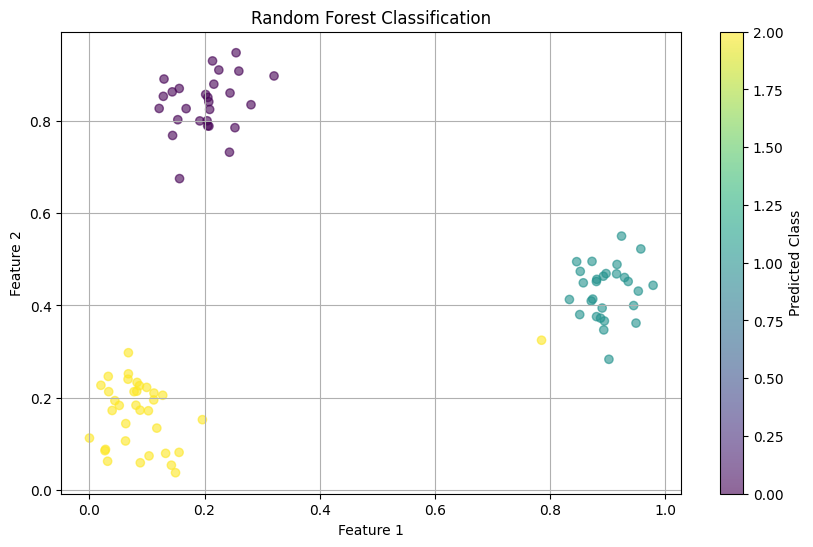

In [ ]:
class RandomForestModel:
    """
    A Random Forest implementation for classification using multiple decision trees.

    Parameters:
    - n_estimators: The number of decision trees in the forest.
    - max_depth: The maximum depth of each decision tree.

    Methods:
    - fit: Train the Random Forest using the training data.
    - predict: Predict the class labels for new data.

    Returns:
    - The predicted class labels for each data point.
    """

    def __init__(self, n_estimators=10, max_depth=None):
        """
        Initialize Random Forest model parameters.

        Parameters:
        - n_estimators: The number of decision trees in the forest (default 10).
        - max_depth: The maximum depth of each tree (default None).
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        """
        Train the Random Forest model.

        Parameters:
        - X: Training feature data.
        - y: Training labels.
        """
        n_samples = X.shape[0]
        for _ in range(self.n_estimators):
            # Bootstrap sample (random sampling with replacement)
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample, y_sample = X[indices], y[indices]
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        """
        Predict the class labels for test data.

        Parameters:
        - X: Test feature data.

        Returns:
        - Predicted class labels for each data point in X.
        """
        # Get predictions from each tree
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        # Use majority vote to determine the final prediction
        return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=tree_predictions)


# Prepare Data
X_train, X_test, y_train, y_test = train_test_split(X_reduced.numpy(), y.numpy(), test_size=0.3, random_state=42)

# Train and predict using custom Random Forest
rf_model = RandomForestModel(n_estimators=10, max_depth=10)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy * 100:.2f}%")

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis', alpha=0.6)
plt.title('Random Forest Classification')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Predicted Class')
plt.grid(True)
plt.show()


### Gradient Boosting Model

Gradient Boosting Accuracy: 98.89%


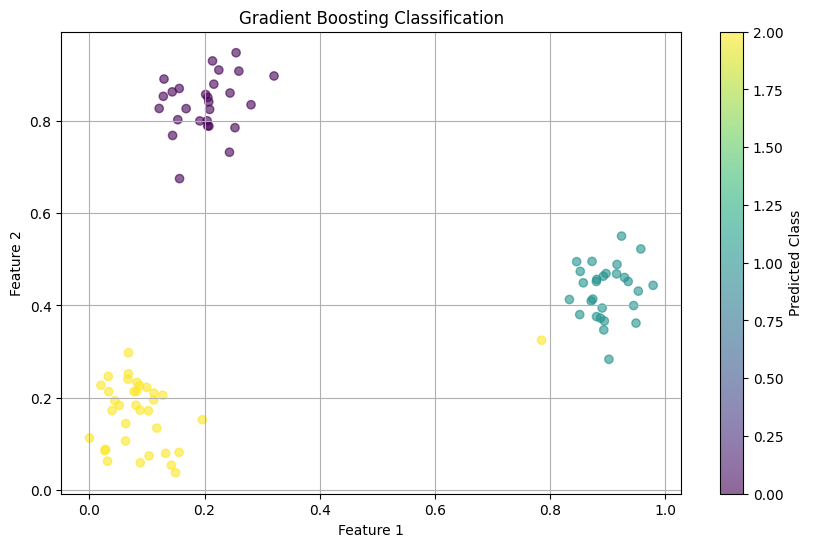

In [ ]:
class GradientBoostingModel:
    """
    A Gradient Boosting implementation for classification using sequential decision trees.

    Parameters:
    - n_estimators: The number of decision trees to be trained sequentially.
    - learning_rate: The rate at which the model corrects the errors from previous trees.
    - max_depth: The maximum depth of each decision tree.

    Methods:
    - fit: Train the Gradient Boosting model using the training data.
    - predict: Predict the class labels for new data.

    Returns:
    - The predicted class labels for each data point.
    """

    def __init__(self, n_estimators=10, learning_rate=0.1, max_depth=None):
        """
        Initialize Gradient Boosting model parameters.

        Parameters:
        - n_estimators: The number of trees (default 10).
        - learning_rate: The step size for updates (default 0.1).
        - max_depth: The maximum depth of each tree (default None).
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.initial_pred = None

    def fit(self, X, y):
        """
        Train the Gradient Boosting model.

        Parameters:
        - X: Training feature data.
        - y: Training labels.
        """
        # Initialize predictions to the mean of the target (classification) or regression value
        self.initial_pred = np.mean(y)
        residuals = y - self.initial_pred

        for _ in range(self.n_estimators):
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X, residuals)  # Fit tree on residuals
            self.trees.append(tree)

            # Update residuals (error)
            predictions = tree.predict(X)
            residuals -= self.learning_rate * predictions

    def predict(self, X):
        """
        Predict the class labels for new data points.

        Parameters:
        - X: Test feature data.

        Returns:
        - Predicted class labels for each data point in X.
        """
        # Start with the initial prediction
        predictions = np.full(X.shape[0], self.initial_pred)

        # Add predictions from each tree, scaled by the learning rate
        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)

        return np.round(predictions).astype(int)


# Prepare Data
X_train, X_test, y_train, y_test = train_test_split(X_reduced.numpy(), y.numpy(), test_size=0.3, random_state=42)

# Train and predict using Gradient Boosting
gb_model = GradientBoostingModel(n_estimators=10, learning_rate=0.1, max_depth=3)
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Gradient Boosting Accuracy: {accuracy * 100:.2f}%")

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis', alpha=0.6)
plt.title('Gradient Boosting Classification')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Predicted Class')
plt.grid(True)
plt.show()
